Author:Fabio Manganiello
Moddified by: Alinne Romero-Torres

Import stuff
------------

In [16]:
import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow import keras

# Change this with the directory where you cloned the imgdetect-utils repo
basedir = os.path.join(os.path.expanduser('~'), 'Documents', 'imgdetect-utils-master', 'imgdetect-utils-master')
sys.path.append(os.path.join(basedir))

from src.image_helpers import plot_images_grid, create_dataset_files
from src.train_helpers import load_data, plot_results, export_model

# The Tensorflow model and properties file will be stored here
tf_model_dir = os.path.join(basedir, 'models', 'ir', 'tensorflow')
tf_model_file = os.path.join(tf_model_dir, 'ir.pb')
tf_properties_file = os.path.join(tf_model_dir, 'ir.json')

# Base directory that contains your training images and dataset files
dataset_base_dir = os.path.join(basedir, 'datasets', 'ir')
dataset_dir = os.path.join(dataset_base_dir, 'data')


# Store your thermal camera images here
img_dir = os.path.join(dataset_base_dir, 'images')

# Size of the input images
input_size = (32, 32)

Create model directories
------------------------

In [17]:
os.makedirs(tf_model_dir, mode=0o775, exist_ok=True)

Create a dataset files from the available images
------------------------------------------------

In [18]:
dataset_files = create_dataset_files(img_dir, dataset_dir,
                                     split_size=500,
                                     num_threads=1,
                                     resize=input_size)
dataset_files

Processing 200 images to 1 dataset files. Format: C:\Users\pc\Documents\imgdetect-utils-master\imgdetect-utils-master\datasets\ir\data\dataset{:01}.npz
Storing dataset vectors to C:\Users\pc\Documents\imgdetect-utils-master\imgdetect-utils-master\datasets\ir\data\dataset0.npz


['C:\\Users\\pc\\Documents\\imgdetect-utils-master\\imgdetect-utils-master\\datasets\\ir\\data\\dataset0.npz']

Or load existing dataset files
------------------------------

In [19]:
dataset_files = [os.path.join(dataset_dir, f)
                 for f in os.listdir(dataset_dir)
                 if os.path.isfile(os.path.join(dataset_dir, f))
                 and f.endswith('.npz')]

dataset_files

['C:\\Users\\pc\\Documents\\imgdetect-utils-master\\imgdetect-utils-master\\datasets\\ir\\data\\dataset0.npz']

Get the training and test set randomly out of the dataset with a split of 70/30
-------------------------------------------------------------------------------

In [20]:
train_set, test_set, classes = load_data(*dataset_files, split_percentage=0.7)
print('Loaded {} training images and {} test images. Classes: {}'.format(
    train_set.shape[0], test_set.shape[0], classes))

Loaded 140 training images and 60 test images. Classes: ['negative' 'positive']


c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
train_images = np.asarray([item[0] for item in train_set])
train_labels = np.asarray([item[1] for item in train_set])
test_images = np.asarray([item[0] for item in test_set])
test_labels = np.asarray([item[1] for item in test_set])

Inspect the first 25 images in the training set
-----------------------------------------------


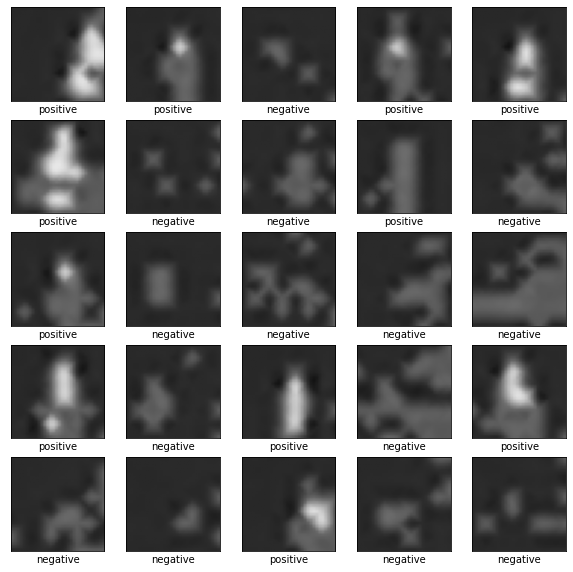

In [22]:
plot_images_grid(images=train_images, labels=train_labels, classes=classes, rows=5, cols=5)


Declare the model
-----------------

* Flatten input
* Layer 1: 60% the number of pixels per image
* Layer 2: 30% the number of pixels per image
* Layer 3: as many neurons as the output labels (in this case 2: negative, positive)

In [23]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=train_images[0].shape),
    keras.layers.Dense(int(0.6 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(int(0.3 * train_images.shape[1] * train_images.shape[2]), activation=tf.nn.relu),
    keras.layers.Dense(len(classes), activation=tf.nn.softmax)
])

Compile the model
-----------------

- *Loss function*:This measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- *Optimizer*: This is how the model is updated based on the data it sees and its loss function.
- *Metrics*: Used to monitor the training and testing steps. The following example uses accuracy, the fraction of the images that are correctly classified.

In [24]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Train the model
---------------

In [25]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
5/5 [==============================] - 1s 20ms/step - loss: 1.2277 - accuracy: 0.4946
Epoch 2/5
5/5 [==============================] - 0s 22ms/step - loss: 0.8956 - accuracy: 0.6283
Epoch 3/5
5/5 [==============================] - 0s 26ms/step - loss: 0.5402 - accuracy: 0.7093
Epoch 4/5
5/5 [==============================] - 0s 23ms/step - loss: 0.6116 - accuracy: 0.6891
Epoch 5/5
5/5 [==============================] - 0s 24ms/step - loss: 0.3894 - accuracy: 0.8946


Evaluate accuracy against the test set
--------------------------------------

In [26]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

2/2 [==============================] - 0s 11ms/step - loss: 0.3474 - accuracy: 0.8667
Test accuracy: 0.8666666746139526


Make predictions on the test set
--------------------------------

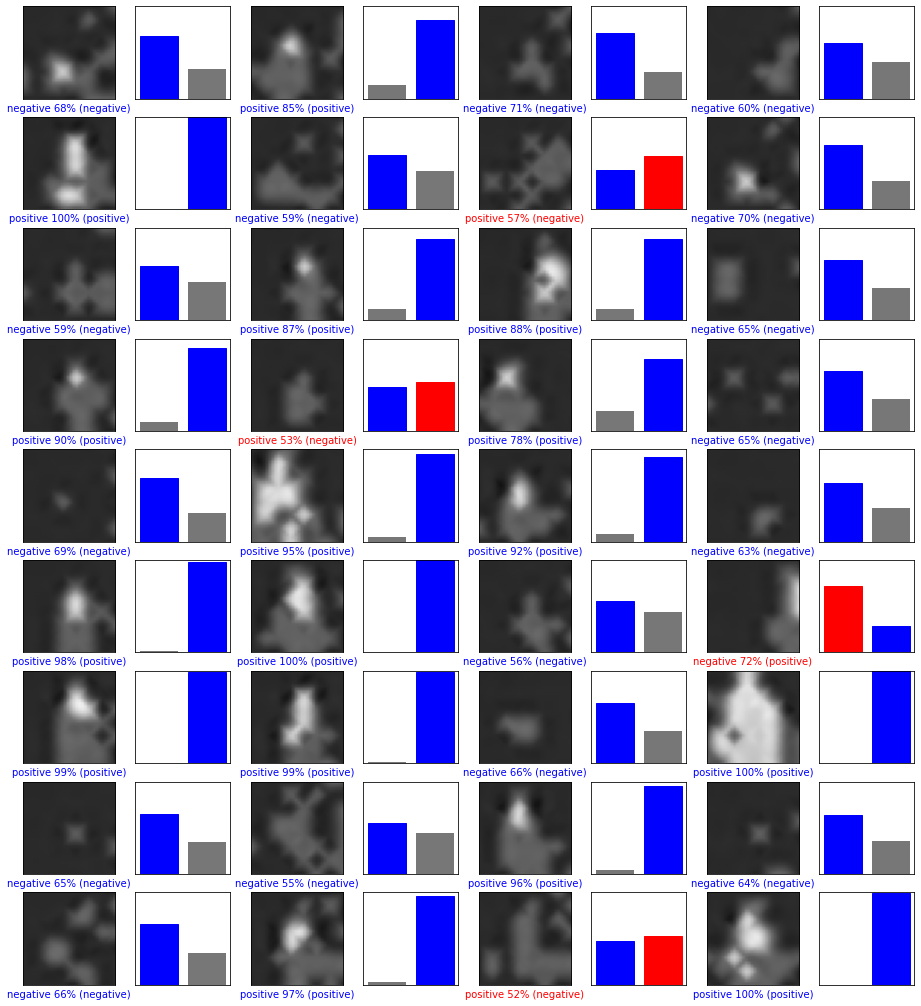

In [27]:
predictions = model.predict(test_images)
plot_results(images=test_images, labels=test_labels, classes=classes, predictions=predictions, rows=9, cols=4)

Export as a Keras model File
----------------------------

In [28]:
keras_file = "model.h5"
keras.models.save_model(model, keras_file)

Convert to Tensor Flow Lite File
----------------------------

In [29]:
# Convert Keras model to a tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()                   
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\pc\AppData\Local\Temp\tmphj38wluu\assets


INFO:tensorflow:Assets written to: C:\Users\pc\AppData\Local\Temp\tmphj38wluu\assets


8307084

In [30]:
# from Digikey's SHAWNHYMEL code
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str

# Write TFLite model to a C source (or header) file
with open("converted_model.tflite" + '.h', 'w') as file:
  file.write(hex_to_c_array(tflite_model, "converted_model.tflite"))